In [ ]:
! pip install pystac-client sat-search 

In [ ]:
! pip install odc.stac

In [1]:
# import required packages
from pystac_client import Client
from odc.stac import stac_load, configure_rio

In [2]:
# VV, VH, AREA = NaN, float32
# angle = 255, uint8
# mask = 0, uint8

# set the collection configuration, setting the products definition 
config = {
    "s1_rtc": {
        "assets": {
            "*": {
                "data_type": "float32",
                "nodata": float('nan'),
                "unit": "1",
            },
            "angle": {
                "data_type": "uint8",
                "nodata": 255,
                "unit": "1",
            },
            "mask": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

In [3]:
# set AWS configuration with specific endpoint
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [4]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")
catalog

ID: DEAfrica_data
Title: Digital Earth Africa
Description: Configure stac endpoint information in your Explorer `settings.env.py` file
type: Catalog
"conformsTo: ['https://api.stacspec.org/v1.0.0-beta.2/core', 'https://api.stacspec.org/v1.0.0-beta.2/item-search']"
ID: Arrivals
Title: Dataset Arrivals
Description: The most recently added Items to this index
title: Dataset Arrivals
type: Collection
properties: {}


In [7]:
# Set a bounding box
# [xmin, ymin, xmax, ymax]
bbox = [-16.34, 12.5699, -16.24, 12.67]

# timeframe
single_date = "2020"

# Set the STAC collections
collections = ["s1_rtc"]

In [8]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime= single_date
)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")
print(items)

Found: 31 datasets
[<Item id=e4d1c5bb-849a-58b6-bd3d-6944b51b879e>, <Item id=152d23bd-a9b9-5c82-b6b3-5ef6f1a73fa3>, <Item id=fdddf3b0-f317-5d2a-a058-60037da0193c>, <Item id=5a3e99c7-be5d-5903-b269-18fc9edea24b>, <Item id=5351e89f-f32a-5927-afe9-020730089b26>, <Item id=52a080fa-b8b1-5f5d-858f-862915eab1ac>, <Item id=3296b299-0ec7-56f8-9044-435d54c47939>, <Item id=e8b00146-cd33-5071-a335-19bc3bbc8524>, <Item id=0623c8ae-3eaa-500e-9230-3fb08346c962>, <Item id=c09f392e-e21c-5e48-ad99-9626a8cf6471>, <Item id=24bf1696-7d1b-5a9d-80fb-9b2404b3cb25>, <Item id=a646def0-b8fd-51f1-9f8d-a10f670d0a9f>, <Item id=607f3199-c3d9-516c-bdad-ccdfde1941da>, <Item id=a38e67ba-1877-5a05-b92b-2a06a01c133f>, <Item id=b18c18de-7f62-54bc-8008-65bda7b749dc>, <Item id=3960bc42-67e9-5878-8ebe-2d85963eecc0>, <Item id=91222481-1309-5596-a820-1f6d51a4306b>, <Item id=2348fafd-9217-5bb9-ae81-682d73718a64>, <Item id=bab17ef4-991f-5de8-a31b-8af89c35abe8>, <Item id=67618b30-281a-5174-975d-6997a828f0e4>, <Item id=d9a34504-95

In [9]:
crs = "EPSG:6933"
resolution = 20

ds = stac_load(
    items,
    bands= ["vv", "vh"],
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox
)

# View the Xarray Dataset
ds

<xarray.Dataset>
Dimensions:      (y: 624, x: 484, time: 31)
Coordinates:
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2020-01-04T19:17:34.083167 ... 2020-12...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>

In [10]:
# import Python packages 
%matplotlib inline

import warnings 
import datacube
import numpy as np
import xarray as xarray
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum

# DEA tools 
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb

In [11]:
# Selecting a few images from the loaded S1 to visualise 
timesteps = [4,6]

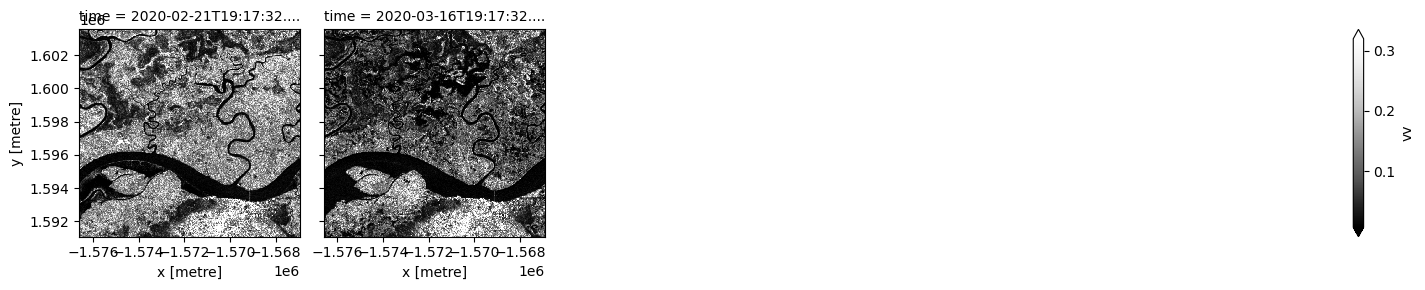

In [12]:
# Plot VV polarisation for specific timeframe 
ds.vv.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

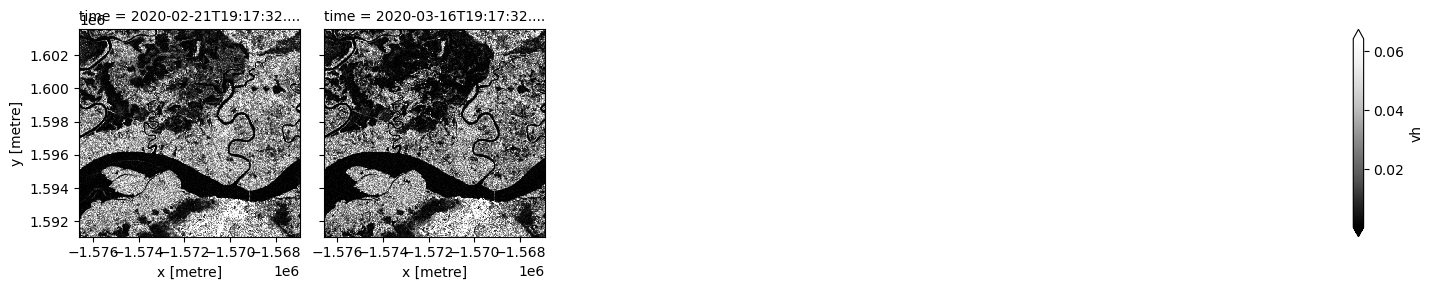

In [13]:
# Plot VH polarisation for specific timeframe 
ds.vh.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

In [15]:
# VH/VV is a potentially useful third feature after VV and VH 
ds['vh/vv'] = ds.vh/ds.vv

In [16]:
ds

<xarray.Dataset>
Dimensions:      (y: 624, x: 484, time: 31)
Coordinates:
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2020-01-04T19:17:34.083167 ... 2020-12...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>
    vh/vv        (time, y, x) float32 dask.array<chunksize=(1, 624, 484), meta=np.ndarray>

In [19]:
new = ds.compute()

In [34]:
# median values are used to scale the measurements so they have a similar range for visualization
med_s1 = new.median()

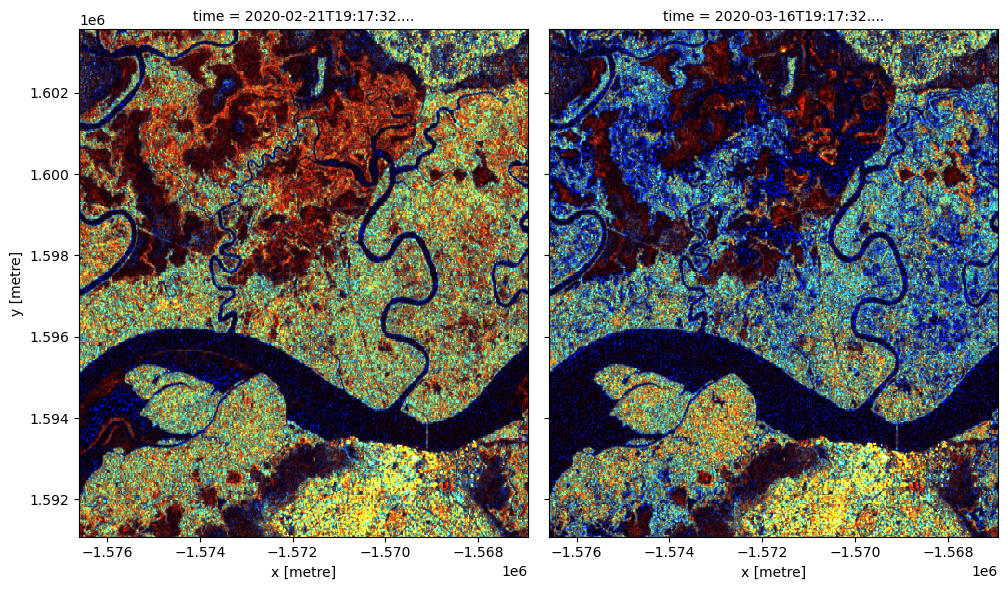

In [25]:
# plotting an RGB image for selected timesteps
rgb(new[['vv', 'vh', 'vh/vv']]/med_s1, bands=['vv',
    'vh', 'vh/vv'], index=timesteps, col_wrap=5);

In [26]:
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [27]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = new.where(~np.isinf(new))
new = new.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
new["filtered_vv"] = new.vv.groupby("time").apply(lee_filter, size=7)
new["filtered_vh"] = new.vh.groupby("time").apply(lee_filter, size=7)

# Null pixels should remain null
new['filtered_vv'] = new.filtered_vv.where(valid.vv, np.nan)
new['filtered_vh'] = new.filtered_vh.where(valid.vh, np.nan)

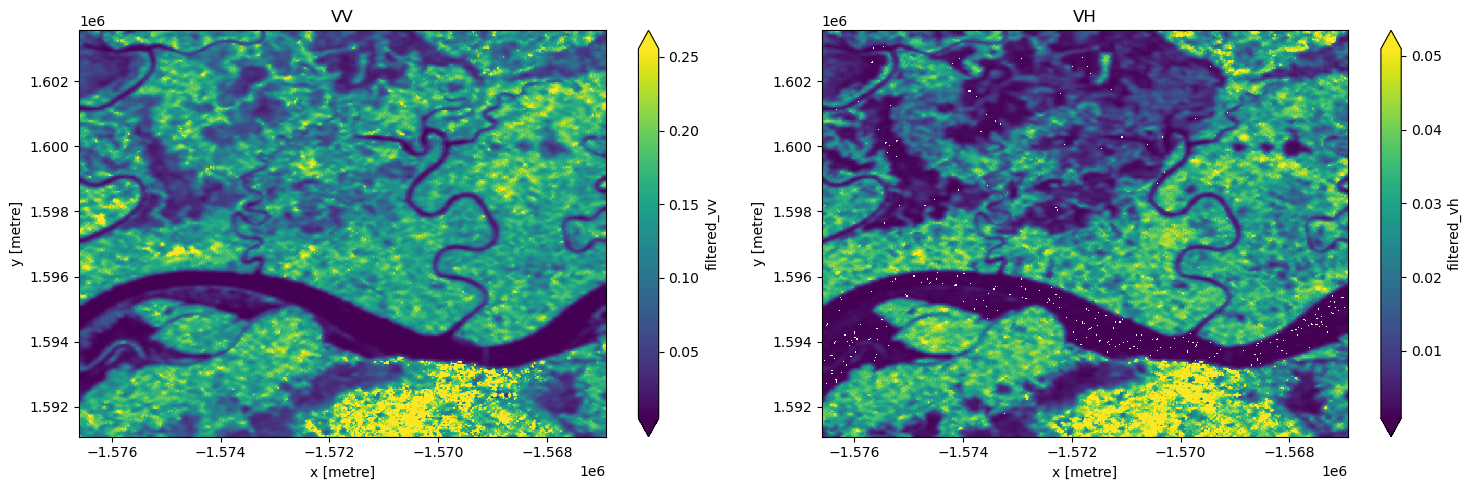

In [28]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
new["filtered_vv"].isel(time=3).plot(ax = ax[0],robust=True)
new["filtered_vh"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

In [30]:
# convert digital numbers to dB
new['filtered_vv'] = 10 * np.log10(new.filtered_vv)
new['filtered_vh'] = 10 * np.log10(new.filtered_vh)

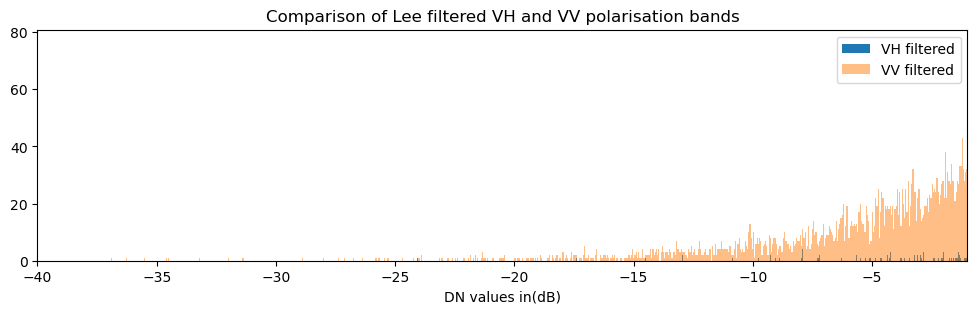

In [32]:
# histogram analysis for S1
fig = plt.figure(figsize=(12, 3))
new.filtered_vh.plot.hist(bins=1000, label="VH filtered")
new.filtered_vv.plot.hist(bins=1000, label="VV filtered",alpha=0.5)
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

In [ ]:
vh_new = new['filtered_vh'].values
vh_new = vh_new[~np.isnan(vh_new)]

threshold_vh = threshold_minimum(vh_new)

print(threshold_vh)

In [ ]:
! pip install --extra-index-url="https://packages.dea.ga.gov.au" git+https://github.com/digitalearthafrica/deafrica-sandbox-notebooks.git#subdirectory=Tools